In [1]:
import pickle 

from collections import defaultdict
from statistics import mean, stdev

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D

In [2]:
# Default parameter for matplotlib
mpl.rcParams['figure.dpi'] = 100

In [3]:
with open('/home/chenghung/DoTA/input/rf_nn_data/weight_rf_data.pickle', mode='rb') as fh:
    x_data, y, tf_list = pickle.load(fh)
    data_order = y[['Gene', 'Tissue']]
    y_data = y['PSI']

In [4]:
gene_list = data_order['Gene'].unique()
tissue_list = data_order['Tissue'].unique()

In [5]:
psi_list = defaultdict(list)
for i, gene in enumerate(data_order['Gene']):
    psi_list[gene].append(y_data[i])

In [6]:
event_counts_per_gene = y.groupby('Gene')['Tissue'].count()
event_counts_per_gene = event_counts_per_gene.to_frame()

In [7]:
gene_counts_across_tissue = event_counts_per_gene.reset_index().groupby('Tissue').count()
gene_counts_cdf = 100 * gene_counts_across_tissue.cumsum()/event_counts_per_gene.count().values

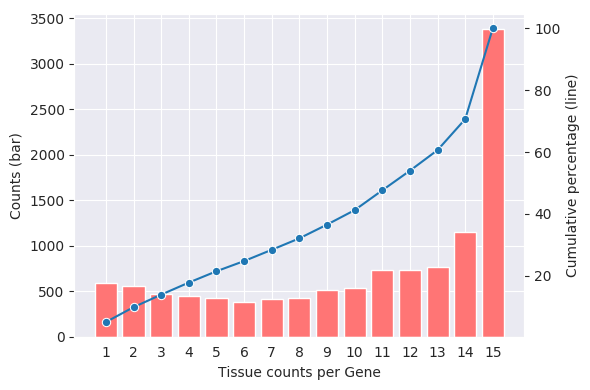

In [8]:
# Estimate tissue counts per gene
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots()
    plt.xlabel('Tissue counts per Gene')
    plt.xticks(range(1, len(gene_counts_across_tissue) + 1))

    ax.bar(gene_counts_across_tissue.index, gene_counts_across_tissue['Gene'], color='#ff7575')
    ax.set_ylabel('Counts (bar)')

    ax2 = plt.twinx()
    ax2 = sns.lineplot(data=gene_counts_cdf, markers='o', legend=False)
    ax2.set_ylabel('Cumulative percentage (line)')
    ax2.grid(None)

    fig.tight_layout()
    # fig.savefig('psi_data_points_stat.png', dpi=300)
    plt.show()

## Create pivot table from y

In [9]:
# Create psi table
psi_df = y.pivot(index='Gene', columns='Tissue')['PSI']

In [10]:
# Remove genes with less than 3 events
psi_df = psi_df[psi_df.notna().sum(axis=1) > 2]

# Calculate stdev
psi_stdev = psi_df.std(axis=1, ddof=0)

# Drop genes with no stdev across different tissues
keep_idx = psi_stdev[psi_stdev != 0].index
psi_df = psi_df.loc[keep_idx]
psi_stdev = psi_stdev[keep_idx]
psi_mean = psi_df.mean(axis=1)

In [11]:
psi_df.to_csv('psi_table.csv')

## Dataframe for plot
Calculate psi mean and reorder the dataframe by it

In [12]:
# Sort by PSI mean
psi_df = psi_df.loc[psi_mean.sort_values().index]

In [13]:
# Z-score
zpsi_df = psi_df.apply(lambda x: (x - psi_mean[x.name]) / psi_stdev[x.name], axis=1)

In [14]:
# Create table for ploting
psi_data = zpsi_df.reset_index(drop=True).T.melt(var_name='sample', value_name='zpsi').dropna()
psi_data['psi'] = psi_df.reset_index(drop=True).T.melt(var_name='sample', value_name='psi').dropna()['psi']
psi_data['sd'] = psi_data['zpsi'].abs()

In [15]:
# Set color code for different SD groups
psi_data['color'] = 'tab:gray'
psi_data.loc[(psi_data['sd'] >= 1) & (psi_data['sd'] < 2), 'color'] = 'tab:blue'
psi_data.loc[(psi_data['sd'] >= 2), 'color'] = 'tab:red'

## PSI Scatter Plot

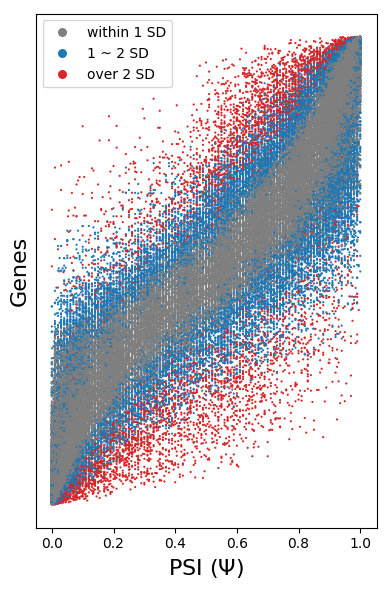

In [16]:
# Shuffle the dataframe for ploting to avoid particular SD group dominant
psi_data = psi_data.sample(frac=1)

# Legend handler
legend_elements = [Line2D([], [], color='w', marker='.',
                          markerfacecolor='tab:gray', markersize=15, label='within 1 SD'),
                   Line2D([], [], color='w', marker='.',
                          markerfacecolor='tab:blue', markersize=15, label='1 ~ 2 SD'),
                   Line2D([], [], color='w', marker='.',
                          markerfacecolor='tab:red', markersize=15, label='over 2 SD')]

# Scatter plot
fig = plt.figure(figsize=(4.0, 6.0))

plt.scatter(x=psi_data['psi'], y=psi_data['sample'],
            s=10, c=psi_data['color'], label=psi_data['color'],
            marker='.', edgecolors='none')
plt.xlabel(r'PSI ($\Psi$)', fontsize=16)
plt.yticks([])
plt.ylabel('Genes', fontsize=16)
plt.legend(handles=legend_elements)

fig.tight_layout()
# fig.savefig('psi_scatterplot.png', dpi=300)
plt.show()

## ZPSI Scatter Plot

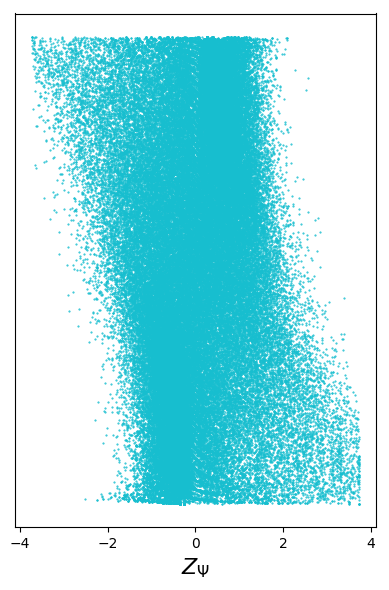

In [17]:
fig = plt.figure(figsize=(4.0, 6.0))

plt.scatter(x=psi_data['zpsi'], y=psi_data['sample'], s=1, c='tab:cyan', marker='.')
plt.xlabel(r'$Z_{\Psi}$', fontsize=16)
plt.yticks([])

fig.tight_layout()
# fig.savefig('psi_zscore_scatterplot.png', dpi=300)
plt.show()